In [1]:
import pandas as pd
import numpy as np
import collections
import sys
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn import svm
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import csv
%matplotlib inline

In [2]:
## Read in dataframes 
data_dir = './WStage2DataFiles/'
# This file provides a master list of cities that have been locations for games played.
df_cities = pd.read_csv(data_dir + 'WCities.csv')
df_gamecities = pd.read_csv(data_dir + 'WGameCities.csv')
df_tourneycompact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tourneydetailed = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_tourneyseeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tourneyslots = pd.read_csv(data_dir + 'WNCAATourneySlots.csv')
df_seasoncompact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_seasondetailed = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_seasons = pd.read_csv(data_dir + 'WSeasons.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
#df_teamspellings = pd.read_csv(data_dir + 'WTeamSpellings.csv') #utf-8 encoding issue
#df_ordinals = pd.read_csv('MasseyOrdinals_thruSeason2018_Day128.csv')

df_tourneydetailed.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,3124,69,3201,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,3173,67,3395,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22
2,2010,138,3181,72,3214,37,H,0,26,57,...,15,3,8,10,21,4,16,6,4,20
3,2010,138,3199,75,3256,61,H,0,25,63,...,20,17,22,16,21,13,16,5,4,24
4,2010,138,3207,62,3265,42,N,0,24,68,...,26,11,17,16,22,9,10,3,4,12


## Calculating Elo Ratings

In [3]:
K = 20.
HOME_ADVANTAGE = 100.

In [4]:
rs = df_seasondetailed.append(df_tourneydetailed, ignore_index=True)

rs.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15


In [5]:
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

350

In [6]:
# This dictionary will be used as a lookup for current
# scores while the algorithm is iterating through each game
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [7]:
# Elo updates will be scaled based on the margin of victory
rs['margin'] = rs.WScore - rs.LScore

In [8]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [9]:
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [10]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in rs.itertuples():
    
    # Get key data from current row
    w = row.WTeamID
    l = row.LTeamID
    margin = row.margin
    wloc = row.WLoc
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [11]:
rs['w_elo'] = w_elo
rs['l_elo'] = l_elo

In [12]:
rs.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,margin,w_elo,l_elo
46836,2017,145,3199,66,3333,53,N,0,27,66,...,11,31,11,23,4,8,18,13,2055.491026,1983.936818
46837,2017,145,3332,77,3268,63,N,0,28,61,...,14,18,9,21,11,7,20,14,2019.086965,2039.431785
46838,2017,145,3376,100,3346,58,N,0,36,59,...,5,13,11,17,6,2,19,42,2101.997751,1806.135720
46839,2017,146,3280,94,3124,85,N,1,32,74,...,10,30,16,17,1,10,19,9,2135.173782,2252.362642
46840,2017,146,3390,76,3323,75,N,0,28,59,...,8,24,11,4,7,1,12,1,2088.719557,2287.015674
46841,2017,147,3163,90,3332,52,H,0,36,66,...,6,20,12,22,2,5,12,38,2486.434192,2017.760962
46842,2017,147,3376,71,3199,64,N,0,26,45,...,18,18,12,11,10,1,18,7,2109.029468,2048.459309
46843,2017,151,3280,66,3163,64,N,1,25,67,...,6,25,11,17,4,8,15,2,2147.043095,2474.564879
46844,2017,151,3376,62,3390,53,N,0,23,63,...,16,25,13,16,8,5,16,9,2118.048399,2079.700626
46845,2017,153,3376,67,3280,55,N,0,25,55,...,9,18,8,10,4,3,19,12,2130.952775,2134.138719


In [13]:
np.mean(-np.log(preds))

0.5155841652334987

In [14]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [15]:
df_list = [final_elo_per_season(rs, id) for id in team_ids]
season_elos = pd.concat(df_list)

In [39]:
season_elos.sample(10)
len(season_elos)

3118

In [41]:
season_elos[(season_elos['season']==2017) &(season_elos['team_id']==3376)]['season_elo'].values[0]

2130.9527747347834

## Getting Season Data

In [42]:
def getSeasonData(team_id, year):
    
    # The data frame below holds stats for every single game in the given year
    df_year = df_seasondetailed[df_seasondetailed['Season'] == year]
    
    # Finding number of points per game
    gamesWon = df_year[df_year.WTeamID == team_id] 
    totalPoints = gamesWon['WScore'].sum()
    gamesLost = df_year[df_year.LTeamID == team_id] 
    totalGames = gamesWon.append(gamesLost)
    numGames = len(totalGames.index)
    totalPoints += gamesLost['LScore'].sum()
    
    # Finding number of points per game allowed
    totalPointsAllowed = gamesWon['LScore'].sum()
    totalPointsAllowed += gamesLost['WScore'].sum()
    
    #FGM - field goals made
    totalFGM = gamesWon['WFGM'].sum()
    totalFGM += gamesLost['LFGM'].sum()
    
    #FGM - field goals made (by opponent)
    totalOppFGM = gamesWon['LFGM'].sum()
    totalOppFGM += gamesLost['WFGM'].sum()
    
    #FGA - field goals attempted
    totalFGA = gamesWon['WFGA'].sum()
    totalFGA += gamesLost['LFGA'].sum()
    
    #FGA - field goals attempted (by opponent)
    totalOppFGA = gamesWon['LFGA'].sum()
    totalOppFGA += gamesLost['WFGA'].sum()
    
    #FGM3 - three pointers made
    totalFGM3 = gamesWon['WFGM3'].sum()
    totalFGM3 += gamesLost['LFGM3'].sum()
    
    #FGM3 - three pointers made (by opponent)
    totalOppFGM3 = gamesWon['LFGM3'].sum()
    totalOppFGM3 += gamesLost['WFGM3'].sum()
    
    #FGA3 - three pointers attempted
    totalFGA3 = gamesWon['WFGA3'].sum()
    totalFGA3 += gamesLost['LFGA3'].sum()
    
    #FGA3 - three pointers attempted (by opponent)
    totalOppFGA3 = gamesWon['LFGA3'].sum()
    totalOppFGA3 += gamesLost['WFGA3'].sum()
    
    #FTM - free throws made
    totalFTM = gamesWon['WFTM'].sum()
    totalFTM += gamesLost['LFTM'].sum()
    
    #FTM - free throws made (by opponent)
    totalOppFTM = gamesWon['LFTM'].sum()
    totalOppFTM += gamesLost['WFTM'].sum()
    
    #FTA - free throws attempted
    totalFTA = gamesWon['WFTA'].sum()
    totalFTA += gamesLost['LFTA'].sum()
    
    #FTA - free throws attempted (by opponent)
    totalOppFTA = gamesWon['LFTA'].sum()
    totalOppFTA += gamesLost['WFTA'].sum()
    
    #OR - offensive rebounds
    totalOR = gamesWon['WOR'].sum()
    totalOR += gamesLost['LOR'].sum()
    
    #OR - offensive rebounds (by opponent)
    totalOppOR = gamesWon['LOR'].sum()
    totalOppOR += gamesLost['WOR'].sum()
    
    #DR - defensive rebounds
    totalDR = gamesWon['WDR'].sum()
    totalDR += gamesLost['LDR'].sum()
    
    #DR - defensive rebounds (by opponent)
    totalOppDR = gamesWon['LDR'].sum()
    totalOppDR += gamesLost['WDR'].sum()
    
    #Ast - assists
    totalAst = gamesWon['WAst'].sum()
    totalAst += gamesLost['LAst'].sum()
    
    #Ast - assists (by opponent)
    totalOppAst = gamesWon['LAst'].sum()
    totalOppAst += gamesLost['WAst'].sum()
    
    #TO - turnovers committed
    totalTO = gamesWon['WTO'].sum()
    totalTO += gamesLost['LTO'].sum()
    
    #TO - turnovers committed (by opponent)
    totalOppTO = gamesWon['LTO'].sum()
    totalOppTO += gamesLost['WTO'].sum()
    
    #Stl - steals
    totalStl = gamesWon['WStl'].sum()
    totalStl += gamesLost['LStl'].sum()
    
    #Stl - steals (by opponent)
    totalOppStl = gamesWon['LStl'].sum()
    totalOppStl += gamesLost['WStl'].sum()
    
    #Blk - blocks
    totalBlk = gamesWon['WBlk'].sum()
    totalBlk += gamesLost['LBlk'].sum()
    
    #Blk - blocks (by opponent)
    totalOppBlk = gamesWon['LBlk'].sum()
    totalOppBlk += gamesLost['WBlk'].sum()
    
    #PF - personal fouls committed
    totalPF = gamesWon['WPF'].sum()
    totalPF += gamesLost['LPF'].sum()
    
    #PF - personal fouls committed (by opponent)
    totalOppPF = gamesWon['LPF'].sum()
    totalOppPF += gamesLost['WPF'].sum()
    
    #Finding tournament seed for that year
    tourneyYear = df_tourneyseeds[df_tourneyseeds['Season'] == year]
    seed = tourneyYear[tourneyYear['TeamID'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournamentSeed = int(seed[1:3])
    else:
        tournamentSeed = 25
    
    # Finding number of wins and losses
    numWins = len(gamesWon.index)
    
    # Creating averages
    if numGames == 0:
        avgPoints = 0
        avgPointsAllowed = 0    
        avgFGM = 0
        avgOppFGM = 0
        avgFGA = 0
        avgOppFGA = 0
        avgFGM3 = 0
        avgOppFGM3 = 0
        avgFGA3 = 0
        avgOppFGA3 = 0
        avgFTM = 0
        avgOppFTM = 0
        avgFTA = 0
        avgOppFTA = 0
        avgOR = 0
        avgOppOR = 0
        avgDR = 0
        avgOppDR = 0
        avgAst = 0
        avgOppAst = 0
        avgTO = 0
        avgOppTO = 0
        avgStl = 0
        avgOppStl = 0
        avgBlk = 0
        avgOppBlk = 0
        avgPF = 0
        avgOppPF = 0
        tournamentSeed = 0
        elo = 0
    else:
        avgPoints = totalPoints/numGames
        avgPointsAllowed = totalPointsAllowed/numGames
        avgFGM = totalFGM/numGames
        avgOppFGM = totalOppFGM/numGames
        avgFGA = totalFGA/numGames
        avgOppFGA = totalOppFGA/numGames
        avgFGM3 = totalFGM3/numGames
        avgOppFGM3 = totalOppFGM3/numGames
        avgFGA3 = totalFGA3/numGames
        avgOppFGA3 = totalOppFGA3/numGames
        avgFTM = totalFTM/numGames
        avgOppFTM = totalOppFTM/numGames
        avgFTA = totalFTA/numGames
        avgOppFTA = totalOppFTA/numGames
        avgOR = totalOR/numGames
        avgOppOR = totalOppOR/numGames
        avgDR = totalDR/numGames
        avgOppDR = totalOppDR/numGames
        avgAst = totalAst/numGames
        avgOppAst = totalOppAst/numGames
        avgTO = totalTO/numGames
        avgOppTO = totalOppTO/numGames
        avgStl = totalStl/numGames
        avgOppStl = totalOppStl/numGames
        avgBlk = totalBlk/numGames
        avgOppBlk = totalOppBlk/numGames
        avgPF = totalPF/numGames
        avgOppPF = totalOppPF/numGames
        elo = season_elos[(season_elos['season']==year) & (season_elos['team_id']==team_id)]['season_elo'].values[0]
    
    return [numWins, avgPoints, avgPointsAllowed, avgFGM, avgOppFGM, avgFGA, avgOppFGA, avgFGM3, avgOppFGM3, avgFGA3, avgOppFGA3,
            avgFTM, avgOppFTM, avgFTA, avgOppFTA, avgOR, avgOppOR, avgDR, avgOppDR, avgAst, avgOppAst, avgTO, avgOppTO, avgStl,
            avgOppStl, avgBlk, avgOppBlk, avgPF, avgOppPF, tournamentSeed, elo]
    

In [43]:
def createSeasonDict(year):
    teamList = df_teams['TeamName'].tolist()
    seasonDictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = df_teams[df_teams['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

In [44]:
def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

## Creating the Training Set

In [45]:
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = df_seasoncompact[df_seasoncompact['Season'] == year]
        totalNumGames += len(season.index)
        tourney = df_tourneycompact[df_tourneycompact['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1246,2010))
    xTrain=[]
    yTrain=[]
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = df_seasoncompact[df_seasoncompact['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = df_tourneycompact[df_tourneycompact['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = []
        yTrainSeason = []
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            if all([x == 0 for x in w_vector]):
                continue
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason.append(diff)
                yTrainSeason.append(1)
            else:
                diff.append(-home)
                xTrainSeason.append([-p for p in diff])
                yTrainSeason.append(0)
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            if all([x == 0 for x in w_vector]):
                continue
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason.append(diff)
                yTrainSeason.append(1)
            else:
                diff.append(-home)
                xTrainSeason.append([-p for p in diff])
                yTrainSeason.append(0)
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain)
    return xTrain, yTrain

In [46]:
years = range(2010,2019)
xTrain, yTrain = createTrainingSet(years)
np.save('xTrain', xTrain)
np.save('yTrain', yTrain)

In [47]:
xTrain.shape, yTrain.shape

((47173, 32), (47173,))

In [48]:
test1 = pd.DataFrame(xTrain)
test1.head(100)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,15.0,10.911905,-10.330952,3.661905,-3.461905,4.659524,-2.104762,1.219048,-1.130952,0.502381,...,1.914286,-0.288095,-1.873810,-1.492857,1.157143,-0.859524,0.454762,0.0,286.788332,1.0
1,2.0,1.103448,0.655172,-1.758621,-0.862069,-2.931034,-3.655172,1.758621,-0.586207,4.758621,...,-3.448276,-0.896552,-2.413793,-0.517241,-0.310345,1.241379,1.517241,0.0,-6.688635,0.0
2,-2.0,3.566502,-5.136289,1.433498,-1.068966,-4.095238,-1.060755,1.908046,-1.180624,3.871921,...,-0.605911,0.159278,-1.423645,2.111658,-0.298851,-1.256158,-0.223317,0.0,128.924806,-1.0
3,-6.0,-7.109010,-1.769744,-2.567297,0.863181,-2.001112,-2.883204,-1.635150,-0.163515,-3.111235,...,-1.850945,-2.659622,-1.362625,-2.998888,-1.102336,-2.618465,-0.224694,0.0,-89.787434,-1.0
4,-1.0,-8.041667,-8.316667,-3.033333,-1.916667,-5.991667,-0.550000,-0.575000,-1.591667,0.350000,...,-3.208333,-1.108333,-1.791667,-0.441667,-0.500000,-1.983333,-0.916667,0.0,16.670425,1.0
5,-4.0,0.875576,2.338710,-1.099078,-0.837558,-2.345622,-0.762673,1.596774,-0.369816,4.092166,...,1.261521,1.389401,0.298387,-2.700461,-0.625576,3.118664,0.414747,0.0,-79.933130,1.0
6,-3.0,-8.030345,-1.998621,-1.482759,-2.320000,0.408276,-5.751724,1.001379,-0.001379,2.292414,...,-1.120000,-1.960000,-1.622069,0.426207,-0.433103,0.478621,-2.877241,0.0,-58.041994,1.0
7,-18.0,-11.949495,6.656566,-2.673401,0.592593,-4.363636,-2.983165,-2.272727,2.127946,-6.138047,...,0.390572,1.821549,3.707071,-0.023569,-1.851852,1.700337,-3.390572,13.0,76.029722,1.0
8,-6.0,3.794624,4.481720,0.601075,0.883871,-0.792473,3.575269,-0.056989,1.146237,-0.186022,...,-1.721505,-0.805376,3.009677,2.010753,-0.783871,-0.160215,3.378495,0.0,-52.969938,-1.0
9,-13.0,-6.100894,13.837803,-4.623244,6.971903,-6.274585,7.459770,-2.118774,1.112388,-4.487867,...,-2.071520,-2.794381,4.721584,-1.823755,1.846743,-1.743295,3.826309,0.0,-246.218538,1.0


## Prelim Model Work

In [49]:
model4 = RandomForestClassifier(n_estimators=200)
model2 = linear_model.BayesianRidge()
model5 = AdaBoostClassifier(n_estimators=100)
model = GradientBoostingRegressor(n_estimators=100)
model3 = KNeighborsClassifier(n_neighbors=101)

In [50]:
def showFeatureImportance(my_categories):
    fx_imp = pd.Series(model.feature_importances_, index=my_categories)
    fx_imp /= fx_imp.max()
    fx_imp.sort()
    fx_imp.plot(kind='barh')

In [51]:
def showDependency(predictions, test, stat, my_categories):
    difference = test[:,my_categories.index(stat)]
    plt.scatter(difference, predictions)
    plt.ylabel('Probability of Team 1 Win')
    plt.xlabel(stat + ' Difference (Team 1 - Team 2)')
    plt.show()

In [52]:
categories = ['numWins', 'avgPoints', 'avgPointsAllowed', 'avgFGM', 'avgOppFGM', 'avgFGA', 'avgOppFGA', 'avgFGM3', 'avgOppFGM3', 'avgFGA3', 'avgOppFGA3',
            'avgFTM', 'avgOppFTM', 'avgFTA', 'avgOppFTA', 'avgOR', 'avgOppOR', 'avgDR', 'avgOppDR', 'avgAst', 'avgOppAst', 'avgTO', 'avgOppTO', 'avgStl',
            'avgOppStl', 'avgBlk', 'avgOppBlk', 'avgPF', 'avgOppPF', 'tournamentSeed', 'elo', 'location']
accuracy=[]
totals=[]
for i in range(1):
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    results1 = model.fit(X_train, Y_train)
    preds1 = model.predict(X_test)
    
    results2 = model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    results3 = model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)

    results4 = model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    results5 = model5.fit(X_train, Y_train)
    preds5 = model5.predict(X_test)
    
    preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5
    totals.append(preds)
    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == Y_test))
    #accuracy.append(np.mean(predictions == Y_test))
print("The accuracy is: ", sum(accuracy)/len(accuracy))

The accuracy is:  0.7807359674410718


/home/aksan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


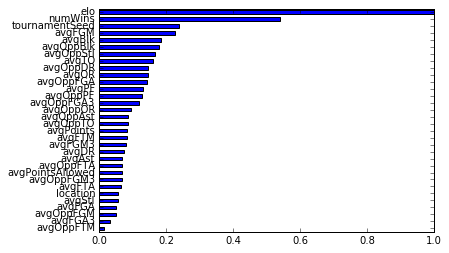

In [53]:
showFeatureImportance(categories)

In [54]:
gb = GradientBoostingClassifier()
params = {'n_estimators': np.arange(10,150,10), 'max_depth': np.arange(1,5,1)}
clf = GridSearchCV(gb, params, scoring='neg_log_loss', refit=True)
clf.fit(xTrain, yTrain)
print('Best log_loss: {:.4}, with best num_estimators: {} and best max_depth: {}'.format(clf.best_score_, clf.best_params_['n_estimators'], clf.best_params_['max_depth']))

Best log_loss: -0.4579, with best num_estimators: 80 and best max_depth: 3


## Prediction for 2018 Submission

In [55]:
def predictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    #return model.predict([diff]) 
    return clf.predict_proba([diff])

In [56]:
sample_sub_pd = pd.read_csv('WSampleSubmissionStage2.csv')
def createPrediction():
    results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
    for index, row in sample_sub_pd.iterrows():
        matchup_id = row['ID']
        year = matchup_id[0:4]
        team1_id = matchup_id[5:9]
        team2_id = matchup_id[10:14]
        team1_vector = getSeasonData(int(team1_id), int(year))
        team2_vector = getSeasonData(int(team2_id), int(year))
        pred = predictGame(team1_vector, team2_vector, 0)
        results[index][0] = matchup_id
        results[index][1] = np.clip(pred[0,1], 0.00000001, 0.999999999)
        #results[index][1] = pred[0][1]
    results = pd.np.array(results)
    firstRow = [[0 for x in range(2)] for x in range(1)]
    firstRow[0][0] = 'id'
    firstRow[0][1] = 'pred'
    with open("Stage2Result.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(firstRow)
        writer.writerows(results)

In [57]:
createPrediction()

In [1]:
#import importlib
#importlib.reload(bracketeer)
%load_ext autoreload
%autoreload 2

from bracketeer_w import build_bracket
b = build_bracket(
        outputPath='bracket3.png', 
        teamsPath='WStage2DataFiles/WTeams.csv',
        seedsPath='WStage2DataFiles/WNCAATourneySeeds.csv',
        submissionPath='Stage2Result.csv',
        slotsPath='WStage2DataFiles/WNCAATourneySlots.csv',
        year=2018
)